# Лабораторная работа 6. 
# Сетевые алгоритмы. Динамические алгоритмы поиска путей.


## Выполнил студент группы БФИ2001 Гуслистый Иван Сергеевич
***

### Задание

1.  Реализовать алгоритм поиска кратчайшего расстояния между двумя вершинами ориентированного взвешенного графа в соответствии с вариантом. 

2.  Предусмотреть задание графа в виде матрицы смежности/инцидентности, читаемой из файла, либо графически с помощью пользовательского интерфейса. 

3.  Разработать графический интерфейс пользователя с визуализацией графа и отображением кратчайшего расстояния между задаваемыми пользователем вершинами.

4. По результатам работы проанализировать временную сложность работы заданного алгоритма в зависимости от числа узлов и ребер графа.
Данные представить в виде таблицы.



### Алгоритмы:

Алгоритм Флойда-Уоршелла| Алгоритм Дейкстры | Алгоритм Беллмана-Форда | Алгоритм Джонсона| Алгоритм Левита | Алгоритм Йена



### Выполнение:

In [ ]:
# Команды для установки нужных библиотек
!pip install matplotlib
!pip install pandas
!pip install networkx

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import queue
from collections import deque

from datetime import datetime as t 

from copy import deepcopy

''' 
    Класс MyGraph содержит реализацию графа из файла .csv с матрицей смежности
    Так же в классе представлены алгоритмы для нахождения путей, реализованные
    в соответствии с заданием
'''


class MyGraph:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.nodes = []
        self.edges = []
        self.df = []

    # Функции получения информации о графе
    def get_graph(self):
        return self.graph

    def get_adj_matrix(self):
        return self.df

    def get_edges(self):
        return self.edges

    def get_nodes(self):
        return self.nodes

    def get_edges_weights(self):
        weights = []
        for edge in self.edges:
            weights.append(edge[2])
        return weights

    def get_edge_weight(self, p1, p2):
        if p1 == p2:
            return 0
        for u, v, w in self.edges:
            if u == p1 and v == p2:
                return w

        return float('inf')

    def get_neighbors(self, p1):
        return nx.neighbors(self.graph, p1)

    # Получаем всё возможнные (их кол-во) пути от source до target
    def get_all_paths(self, source, target):
        return len(list(nx.all_simple_paths(self.graph, source, target)))

    def add_node(self, n):
        self.nodes.append(n)
        self.graph.add_node(n)
        return 0

    def add_edge(self, p1, p2, w):
        for edge in self.edges:
            if p1 == edge[0] and p2 == edge[1]:
                self.edges.remove(edge)
                # break

        if p1 in self.nodes and p2 in self.nodes:
            self.edges.append((p1, p2, w))
            self.graph.add_edge(p1, p2, weight=w)
            return 0

        return -1

    def remove_node(self, node):
        self.graph.remove_node(node)
        self.nodes.remove(node)
        temp = []
        for edge in self.edges:
            if edge[0] != node and edge[1] != node:
                temp.append(edge)

        self.edges = temp

    def make_graph_from_csv(self, filename):
        self.df = pd.read_csv(filename)

        # Получаем имена вершин
        self.nodes = list(self.df.keys())
        self.edges = []

        # Цикл формирования рёбер
        for i in range(len(self.df.values)):
            for j in range(len(self.df.values[i])):
                # Если вершины смежны, то формируем ребро
                if self.df.values[i][j] != 0:
                    self.edges.append((self.nodes[i], self.nodes[j], self.df.values[i][j]))

        # Добавляем вершины и соединяем их
        self.graph.add_nodes_from(self.nodes)
        self.graph.add_weighted_edges_from(self.edges)

    # Рисуем граф
    def draw_graph(self, text, x, y):
        # Расположение графа
        pos = nx.circular_layout(self.graph)
        nx.draw(self.graph, pos=pos, node_size=500, with_labels=True)

        # Отображаем веса рёбер
        weights = nx.get_edge_attributes(self.graph, 'weight')
        nx.draw_networkx_edge_labels(self.graph, pos=pos, edge_labels=weights)

        # Выводим граф на экран с текстом (вывод - найденные пути в виде строки)
        plt.text(x, y, text)
        plt.show()

    # Алгоритм Уоршелла-Флойда (использовать только при наличии отрицательных рёбрах)
    def warshall_floyd(self, s, t):
        # Восстанавливаем путь
        def construct_path(predessors, p1, p2, pth):
            if p1 == p2:
                path.append(p1)
                return path
            else:
                path.append(p2)
                construct_path(predessors, p1, pred[p1][p2], pth)

        all_nodes = self.get_nodes()
        distance = {}
        pred = {}

        # Если нет отрицательных рёбер, то найдём кр. путь с помощью Дейкстры
        e = self.get_edges_weights()
        if all(e[i] >= 0 for i in range(len(e))):
            return self.dijkstra(s, t)

        # Формируем матрицы для расстояний и предшественников
        # Из предшественников будет восстановлен нужный путь
        for n1 in all_nodes:
            distance[n1] = {}
            pred[n1] = {}
            for n2 in all_nodes:
                w = self.get_edge_weight(n1, n2)
                distance[n1][n2] = w
                pred[n1][n2] = n1

        # Последовательно находим кратчайшие пути
        # И предшественников
        for k in all_nodes:
            for u in all_nodes:
                for v in all_nodes:
                    newdist = distance[u][k] + distance[k][v]
                    if newdist < distance[u][v]:
                        distance[u][v] = newdist
                        pred[u][v] = pred[k][v]

        # Восстанавливаем путь
        path = []
        construct_path(pred, s, t, path)
        path.reverse()

        return [distance[s][t], path]

    # Алгоритм Дейкстры
    # Если нет target, то будут вывдены кратчайшие пути от source до всех вершин
    def dijkstra(self, s, t=None):
        # Получаем все вершины для нахождения
        queue = deepcopy(self.nodes)

        # Словарь конечная вершина : [расстояние, путь]
        distance = {}
        for node in self.get_nodes():
            # Изначально устанавливаем расстояние равное бесконечности
            distance[node] = [float("inf"), s]

        # Расстояние до source равно нулю
        distance[s] = [0, [s]]

        # Просмотренные вершины
        seen = set()

        # Пока не будет найден путь для всех вершин
        while queue:

            # Получаем вершину, которая ещё не была рассмотрена
            # и расстояние до которой минимально (от источника)
            min_dist = float('inf')
            min_node = None
            for n in queue:
                if distance[n][0] < min_dist and n not in seen:
                    min_dist = distance[n][0]
                    min_node = n

            if min_node not in queue:
                break

            # Удаляем и зала ожидания рассмотренную вершину
            queue.remove(min_node)
            seen.add(min_node)
            # Получаем всех следующих соседей
            neighbors = nx.neighbors(self.get_graph(), min_node)
            connections = [(self.get_graph().get_edge_data(min_node, n)['weight'], n) for n in neighbors]

            # Для каждого соседа обновляем путь и полное расстояние от исходного узла
            # если полное расстояние меньше уже полученного
            for (weight, node) in connections:
                # Полное расстояние
                tot_dist = weight + min_dist
                if tot_dist < distance[node][0]:
                    distance[node][0] = tot_dist
                    distance[node][1] = list(distance[min_node][1])
                    distance[node][1].append(node)

        if t:
            return distance[t]
        else:
            return distance

    # Алгоритм Белламана-Форда (если в графе рёбра с отрицательным весом)
    def bellman_ford(self, s, t=None):
        # Получаем все вершины для нахождения
        all_nodes = deepcopy(self.nodes)

        # Словарь конечная вершина : [расстояние, путь]
        distance = {}

        for node in all_nodes:
            distance[node] = [float("inf"), [s]]
        distance[s] = [0, [s]]

        # Для каждой вершины находим кратчайший путь от source до этой вершины
        for i in range(len(all_nodes)):
            for u, v, w in self.edges:
                if distance[u][0] + w < distance[v][0]:
                    distance[v][0] = distance[u][0] + w
                    distance[v][1] = list(distance[u][1])
                    distance[v][1].append(v)

        # Проверяем есть ли в графе циклы с отрицательным весом
        for u, v, w in self.get_edges():
            if distance[u][0] != float('inf') and distance[u][0] + w < distance[v][0]:
                return [float('inf'), []]

        if t:
            return distance[t]
        else:
            return distance

    # Алгоритм Левита (ещё один метод обхода с отрицательными врешинами)
    def johnson(self, s, t=None):
        e = deepcopy(self.edges)

        # Если нет отриц. рёбер
        if all(e[i][2] >= 0 for i in range(len(e))):
            return self.dijkstra(s, t)

        # Добавляем шпиона (для избавления от отрицательных вершин)
        self.add_node('S')
        for node in self.nodes:
            if node == 'S':
                continue
            self.add_edge('S', node, 0)

        # Находим все кратчайшие маршруты (отрицательные пути)
        h = self.bellman_ford('S')
        self.remove_node('S')

        # Убираем отрицательные числа из графа
        for u, v, w in e:
            self.add_edge(u, v, w + h[u][0] - h[v][0])

        # Находим путь через Дейкстру
        path = self.dijkstra(s, t) if t else self.dijkstra(s)

        # Возвращаем рёбра (их веса) обратно
        for u, v, w in e:
            self.add_edge(u, v, w)

        return path

    # Алгоритм Левита (находим кратчайший путь от p1 до p2)
    def levit(self, s, t=None):
        # Восстанавляваем путь
        def construct_path(predessors, p1, p2, pth):
            if p1 == p2:
                pth.append(p1)
                return pth
            else:
                pth.append(p2)
                construct_path(predessors, p1, predessors[p1][p2], pth)

        all_nodes = deepcopy(self.nodes)

        distance = {}
        pred = {}
        # Массив, который обозначет была ли вершина уже вычислена
        states = {}
        for n1 in all_nodes:
            distance[n1] = float('inf')
            pred[n1] = -1
            states[n1] = 2

        distance[s] = 0
        states[s] = 0
        pred[s] = s

        # Используем двусвязную очередь,
        # Справа вершины, расстояние до которых ещё не вычислено
        # Слева вершины, расстояние, до которых вычислено (но не точно)
        q = deque()
        q.appendleft(s)

        while q:
            v = q.pop()
            states[v] = 0

            # Проходимся по соседям от текущей вершины
            for to in self.get_neighbors(v):
                # Расстояние до соседа
                length = self.get_edge_weight(v, to)

                if distance[to] > distance[v] + length:
                    distance[to] = distance[v] + length

                    # Если вершина ещё не была просмотрена
                    if states[to] == 2:
                        q.appendleft(to)

                    # Если уже просмотрена
                    elif states[to] == 0:
                        q.append(to)

                    pred[to] = v
                    states[to] = 1

        # Если путь не был найден
        if pred[t] == -1:
            return 0
        # Иначе восставливем путь и расстояние
        else:
            pred = {s: pred}
            path = []
            construct_path(pred, s, t, path)
            path.reverse()
            return [distance[t], path]

    # Алгоритм Йены
    def yen(self, p1, p2, K):

        # Определяем самый первый кратчайший путь и его стоимость
        # A = [nx.dijkstra_path(self.graph, p1, p2)]
        f_path = self.dijkstra(p1, p2)
        A = [f_path[1]]
        A_costs = [f_path[0]]

        # Кандидаты, приоритетная очередь
        B = queue.PriorityQueue()

        for k in range(1, K):
            # Узел ветвления (от которого будем искать новый кратчайший путь)
            # в диапазоне от первого узла до последнего в предыдущем к-кратчайшем пути
            for i in range(len(A[k - 1]) - 1):
                # Узел ветвления получаем из предыдущего кратчайшего пути
                spur_node = A[k - 1][i]
                # Корневой путь - последовательность узлов от источника (p1) до узла ветвления
                root_path = A[k - 1][:i]

                removed_edges = []

                for path in A:
                    # Удаляем ребро, которое является чатью предыдущего кратчайшего пути и корневого пути
                    if len(path) - 1 > i and root_path == path[:i] and self.graph.has_edge(path[i], path[i + 1]):
                        edge_weight = self.graph.edges[path[i], path[i + 1]]['weight']

                        removed_edges.append((path[i], path[i + 1], edge_weight))
                        self.graph.remove_edge(path[i], path[i + 1])

                # Если есть вообще путь от узла до конца (p2)
                if nx.has_path(self.graph, spur_node, p2):
                    # Находим путь
                    spur_path = nx.dijkstra_path(self.graph, spur_node, p2)

                    # Формируем весь новый путь от p1 до p2
                    total_path = root_path + spur_path
                    total_path_cost = nx.dijkstra_path_length(self.graph, total_path[0], total_path[-1])

                    # Добавляем в список кандидатов
                    B.put((total_path_cost, total_path))

                # Восстанавливаем удалённые рёбра
                self.graph.add_weighted_edges_from(removed_edges)

            # Так как кандидаты - приоритетная очередь, то они уже отсортированы
            # Находим наименьший путь из кандидатов и добавляем в стоимости и кратчайшие пути
            while not B.empty():
                cost_, path_ = B.get()
                if path_ not in A:
                    A.append(path_)
                    A_costs.append(cost_)
                    break

        return A, A_costs

___
Функция формирования строки для вывода алгоритма и пути

In [22]:
def output_path(p, alg):
    out_text = alg + ': \n'

    for i in p[1]:
        out_text += '{} ->'.format(i)

    return out_text + ' ' + str(p[0])

___
Создание объекта нашего графа и формирование рёбер и вершин

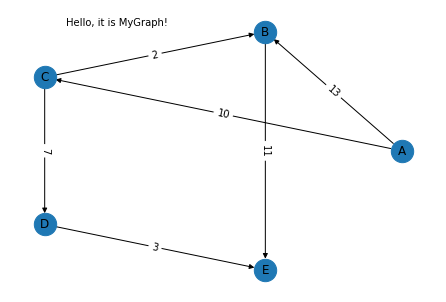

In [23]:
gr = MyGraph()

# Формируем граф из файла (матрицы смежности)
gr.make_graph_from_csv("AdjacencyMatrix.csv")

gr.draw_graph("Hello, it is MyGraph!", -0.7, 1)

___
Алгоритм Уоршелла-Флойда, вывод пути на график

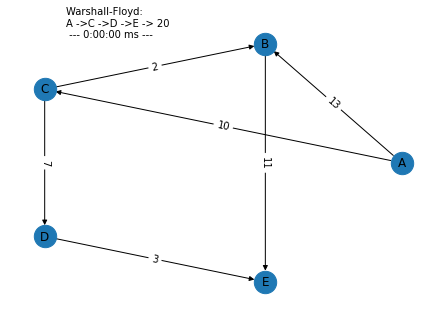

In [28]:
source = 'A'
target = 'E'

time_ = t.now()

path = gr.warshall_floyd(source, target)

time_ = "\n --- {0} ms ---".format((t.now() - time_))

gr.draw_graph(output_path(path, 'Warshall-Floyd') + time_, -0.7, 1)

___
Алгоритм  Дейкстры, вывод пути на график

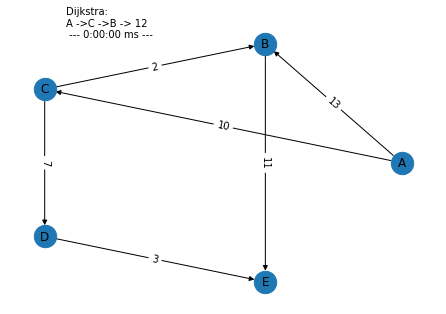

In [30]:
source = 'A'
target = 'B'

time_ = t.now()

path = gr.dijkstra(source, target)

time_ = "\n --- {0} ms ---".format((t.now() - time_))

gr.draw_graph(output_path(path, 'Dijkstra') + time_, -0.7, 1)

___
Алгоритм  Беллмана-Форда, вывод пути на график

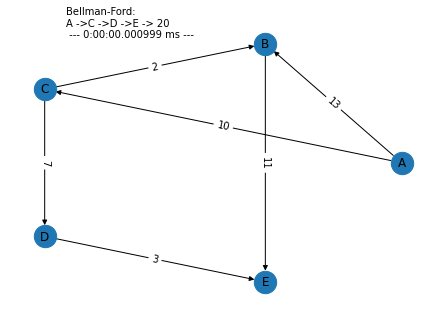

In [32]:
source = 'A'
target = 'E'

time_ = t.now()

path = gr.bellman_ford(source, target)

time_ = "\n --- {0} ms ---".format((t.now() - time_))

gr.draw_graph(output_path(path, 'Bellman-Ford') + time_, -0.7, 1)

___
Алгоритм Джонсона, вывод пути на график

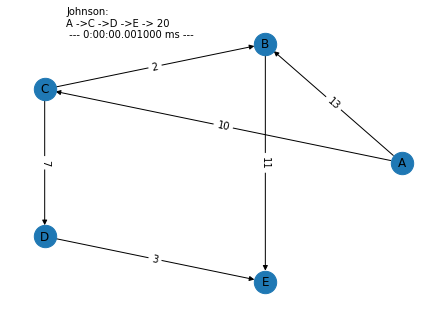

In [33]:
source = 'A'
target = 'E'

time_ = t.now()

path = gr.johnson(source, target)

time_ = "\n --- {0} ms ---".format((t.now() - time_))

gr.draw_graph(output_path(path, 'Johnson') + time_, -0.7, 1)

___
Алгоритм Левита, вывод пути на график

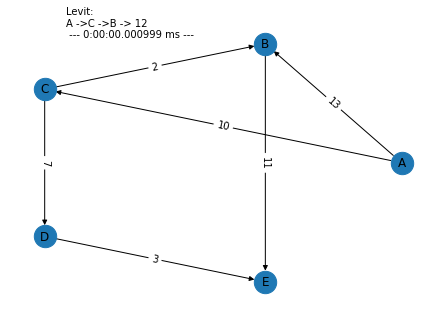

In [34]:
source = 'A'
target = 'B'

time_ = t.now()

path = gr.levit(source, target)

time_ = "\n --- {0} ms ---".format((t.now() - time_))

gr.draw_graph(output_path(path, 'Levit') + time_, -0.7, 1)

___
Алгоритм Йены, вывод путей на график

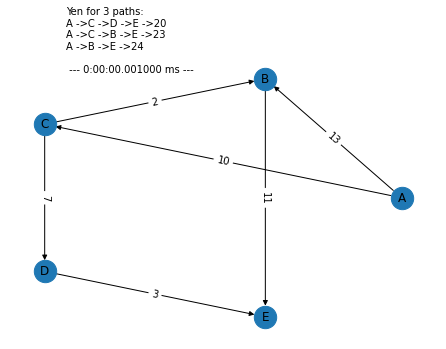

In [35]:
def output_path_yen(p, c):
    out_text = 'Yen for {} paths: \n'.format(len(p))

    for path in range(len(p)):
        for v in range(len(p[path])):
            out_text += '{} ->'.format(p[path][v])
            
        out_text += str(c[path]) + '\n'
        
    return out_text

source = 'A'
target = 'E'
k = 3

time_ = t.now()

paths, costs = gr.yen(source, target, k)

time_ = "\n --- {0} ms ---".format((t.now() - time_))

gr.draw_graph(output_path_yen(paths, costs) + time_, -0.7, 1)

### Вывод